In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2023-01-20 17:02:48--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   821KB/s    in 1.2s    

2023-01-20 17:02:50 (821 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [4]:
df = pd.read_csv('ml-latest-small/ratings.csv')
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_join = pd.merge(df_movies, df, how='inner', on='movieId')
df_join

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [38]:
# get ratings, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column 

def get_ratings(df, n_dims=20, train_size=0.8):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    n_dims = n_dims
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 3])
    uniq_movies = np.unique(df_values[:, 0])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = movie_to_column[row.movieId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column

In [39]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings(df_join, 20, 0.8)
parameters = {}

In [42]:
class PMF():
    def initialize_parameters(self, lambda_U, lambda_V):
        U = np.zeros((n_dims, n_users), dtype=np.float64) # user
        V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies)) # item (movie)
        
        parameters['U'] = U
        parameters['V'] = V
        parameters['lambda_U'] = lambda_U
        parameters['lambda_V'] = lambda_V

    def update_parameters(self): #stochastic graident descent
        U = parameters['U']
        V = parameters['V']
        lambda_U = parameters['lambda_U']
        lambda_V = parameters['lambda_V']
        
        # update user matirx U
        for i in range(n_users):
            V_j = V[:, R[i, :] > 0]
            U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))

        # update item matirx V    
        for j in range(n_movies):
            U_i = U[:, R[:, j] > 0]
            V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
            
        parameters['U'] = U
        parameters['V'] = V

    def log_a_posteriori(self):
        lambda_U = parameters['lambda_U']
        lambda_V = parameters['lambda_V']
        U = parameters['U']
        V = parameters['V']
        
        UV = np.dot(U.T, V)
        R_UV = (R[R > 0] - UV[R > 0])
        
        return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T))) # log of the posterior (for Maximize)

    def predict(self, user_id, movie_id):
        U = parameters['U']
        V = parameters['V']
        
        r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

        max_rating = parameters['max_rating']
        min_rating = parameters['min_rating']

        return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

    def evaluate(self, dataset):
        ground_truths = []
        predictions = []
        
        for index, row in dataset.iterrows():
            ground_truths.append(row.loc['rating'])
            predictions.append(self.predict(row.loc['userId'], row.loc['movieId']))
        
        return mean_squared_error(ground_truths, predictions, squared=False) # RMSE 

    def update_max_min_ratings(self):
        U = parameters['U']
        V = parameters['V']

        R = U.T @ V
        min_rating = np.min(R)
        max_rating = np.max(R)

        parameters['min_rating'] = min_rating
        parameters['max_rating'] = max_rating

    def train(self, n_epochs):
        self.initialize_parameters(random.random(), random.random())
        log_aps = []
        rmse_train = []
        rmse_test = []

        self.update_max_min_ratings()
        rmse_train.append(self.evaluate(train_set))
        rmse_test.append(self.evaluate(test_set))
        
        for k in range(n_epochs):
            self.update_parameters()
            log_ap = self.log_a_posteriori()
            log_aps.append(log_ap)

            if (k + 1) % 10 == 0:
                self.update_max_min_ratings()

                rmse_train.append(self.evaluate(train_set))
                rmse_test.append(self.evaluate(test_set))
                print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

        self.update_max_min_ratings()

        return log_aps, rmse_train, rmse_test

In [43]:
log_ps, rmse_train, rmse_test = PMF().train(100)

Log p a-posteriori at iteration 10 : -17514.93205773317
Log p a-posteriori at iteration 20 : -9571.54848449421
Log p a-posteriori at iteration 30 : -7572.2416920299165
Log p a-posteriori at iteration 40 : -6696.840020617453
Log p a-posteriori at iteration 50 : -6207.4268947328665
Log p a-posteriori at iteration 60 : -5856.634641802876
Log p a-posteriori at iteration 70 : -5581.037809609388
Log p a-posteriori at iteration 80 : -5371.893358290353
Log p a-posteriori at iteration 90 : -5213.274422906093
Log p a-posteriori at iteration 100 : -5086.573746361857


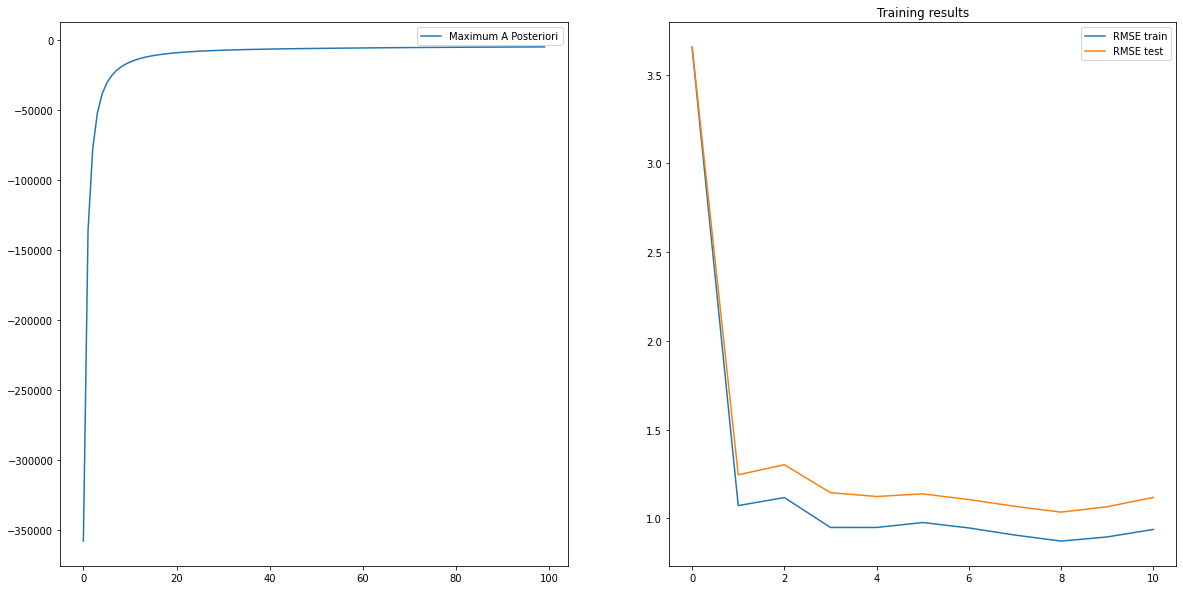

In [44]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='Maximum A Posteriori')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

In [45]:
print('RMSE of training set:', PMF().evaluate(train_set))
print('RMSE of testing set:', PMF().evaluate(test_set))

RMSE of training set: 0.9367610418092331
RMSE of testing set: 1.1173131259533817
